## Importando bibliotecas

In [1]:
using Plots
using FFTW
using SpecialFunctions
using LinearAlgebra

## 1. Experimento da reciprocidade do campo de onda elástico e acústico

****

### 1.1 Metodologia

Os testes foram realizados com base no paper *Reciprocity in elastic multi-component data*, no qual é explorado o cálculo da reciprocidade do campo de pressão e velocidade para caso elástico. 

Para realizar averiguar a reciprocidade do campo de onda, primeiro fizemos uma propagação direta usando o termo fornte como um quadipolo da velocidade, que é o mesmo que injetar a fonte nas componentes diagonais do tensor de tensão. Posteriormente, realizamos três propagações distintas, trocando da posição da fonte pelo posição do receptor, para valiar a reciprocidade do campo de pressão, da componente horizontal da velocidade e da componente vertical separadamente, seguindo as orientações do paper citado.

### 1.2 Experimentos

Foram 3 experimentos distintos, o primeiro com tanto a fonte quando o receptor no meio acústico, o segundo com ambos no leito marinho (ainda em meio acústico) e o terceiro com a fonte e receptor em meios distintos (Elástico e acústico). Em todos os três, a reciprocidade do campo de velocidade foi obedecida.

* Reciprocidade do campo de pressão:

Para avaliar o campo de pressão não foi preciso mudar o tipo de fonte e nem a forma como o campo é gravado no receptor, pois essa componente é acústica. Ou seja, para avaliar esse reciprocidade bastou trocar a posição da fonte pela posição do receptor.

* Reciprocidade do campo de velocidade horizontal:

Para avaliar a recipocidade do campo de velocidade horizontal, injetamos uma fonte monopolo na direção horizontal e gravamos o campo de velocidade horizontal recíproco como um quadripolo do campo de velocidade.

* Reciprocidade do campo de velocidade vertical:

Para avaliar a recipocidade do campo de velocidade vertical, injetamos uma fonte monopolo na direção vertical e gravamos o campo de velocidade vertical recíproco como um quadripolo do campo de velocidade.

### 1.3 Conclusão

Para avaliar a reciprocidade do campo de pressão não foi preciso mudanças na propagação. Já para as componentes da velocidade, para avaliar a reciprocidade precisamos inverter os cenários, em outras palavras, para uma fonte explosiva (quadripolo da velocidade), para fazer a propagação recíproca precisamos injetar um fonte monopolo ao longo da direção correspondente e medir o campo de velocidade na mesma direção como um quadripolo do campo de velocidade.

In [2]:
function estendermodelo(vel,borda,topbc)
    (nz,nx)=size(vel)
    nxa=nx+2*borda
    if topbc == "abbc"
        nza=nz+2*borda
        modelo=zeros(eltype(vel),nza,nxa)
        modelo[borda+1:borda+nz,borda+1:borda+nx]=vel
        recheio=vel[:,1]
        for i=1:borda
            modelo[borda+1:borda+nz,i].=recheio
        end
        recheio=vel[:,nx]
        for i=borda+nx+1:nxa
            modelo[borda+1:borda+nz,i].=recheio
        end
        recheio=modelo[borda+nz,:]
        for i=borda+nz+1:nza
            modelo[i,:].=recheio
        end
        recheio=modelo[borda+1,:]
        for i=1:borda
            modelo[i,:].=recheio
        end
    elseif topbc == "free"
        nza=nz+borda
        modelo=zeros(eltype(vel),nza,nxa)
        modelo[1:nz,borda+1:borda+nx]=vel
        recheio=vel[:,1]
        for i=1:borda
            modelo[1:nz,i].=recheio
        end
        recheio=vel[:,nx]
        for i=borda+nx+1:nxa
            modelo[1:nz,i].=recheio
        end
        recheio=modelo[nz,:]
        for i=nz:nza
            modelo[i,:].=recheio
        end
    end
    return modelo
end

function taper(nz, nx, borda, topbc)
    nxa=nx
    nza=nz
    amortece=ones(nza,nxa)
    for j=1:nxa
        if topbc == "abbc"
            for i=1:borda
                amortece[i,j]=amortece[nza-i+1,j]=exp(-(0.3*(borda-i)/borda)^2)
            end
        elseif topbc == "free"
            for i=1:borda
                amortece[nza-i+1,j]=exp(-(0.3*(borda-i)/borda)^2)
            end
        end
    end
    for j=1:borda
        for i=1:nza
            amortece[i,j]*=exp(-(0.3*(borda-j)/borda)^2)
            amortece[i,nxa-j+1]*=exp(-(0.3*(borda-j)/borda)^2)
        end
    end
    return amortece
end

function wavelet(f_corte, t)

    f_c = f_corte/(3*sqrt(pi))
    t_0 = (2*sqrt(pi))/f_corte
    t_d = t .- t_0

    src = -(2*pi^3 .*(f_c .*t_d).^2 .- 1) .* exp.(-(pi^3 .*(f_c .*t_d).^2))
    return src

end

function Prop2D_direct_elastico(nx,nz,nt,dx,dz,dt,source,rho,cp,cs,amortecedor,ixs,izs,ixr,izr)
    
    traceP = zeros(Float32, nt)
    traceVx = zeros(Float32, nt)
    traceVz = zeros(Float32, nt)

    # Parâmetros do meio
    dtdx::Float32 = dt/dx
    rlamu = cp.* cp .* rho
    rmu = cs .* cs .* rho
    rla = rlamu .- (2.0 .* rmu)

    bzz = zeros(Float32, nz, nx) # Variação da densidade na direção z
    bxx = zeros(Float32, nz, nx)  # Variação da densidade na direção x
    C55 = zeros(Float32, nz, nx)
    C = zeros(Float32, 6, 6, nz, nx) # Módulos Elástico

    for i in 1:6
        for j in 1:6
            if i == j && i < 4
                C[i, j, :, :] = rlamu 
            elseif i == j && i >= 4
                C[i, j, :, :] = rmu 
            elseif i == 1 && (j == 2 || j == 3)
                C[i, j, :, :] = rla 
            elseif i == 2 && (j == 1 || j == 3)
                C[i, j, :, :] = rla
            elseif i == 3 && (j == 1 || j == 2)
                C[i, j, :, :] = rla
            end
        end
    end

    for i in 2:nz-1
        for k in 2:nx-1
            bzz[i,k] = 0.5 * (1/rho[i - 1, k] + 1/rho[i, k])
            bxx[i,k] = 0.5 * (1/rho[i, k - 1] + 1/rho[i, k])
            C55[i,k] = (0.25*(1/C[5,5,i,k] + 1/C[5,5,i+1,k] + 1/C[5,5,i+1,k+1] + 1/C[5,5,i,k+1]))^(-1)
            if C[5,5,i,k] == 0 0
                C55[i,k] = 0.0
            end
        end
    end

    # Coeficiente da aproximação de segunda ordem para a derivada
    g1::Float32 = -1.0 / 24.0
    g2::Float32 = 9.0 / 8.0

    eps = 1/24 + 9/8
    if (maximum(cp)*dt/dx <= 1/eps)

        println("Critério de estabilidade obedecido")

        soufac::Float32 = dt / (dx * dz)
        vx = zeros(Float32,nz, nx)
        vz = zeros(Float32,nz, nx)
        txx = zeros(Float32,nz, nx)
        tzz = zeros(Float32,nz, nx)
        txz = zeros(Float32,nz, nx)
        exx = zeros(Float32,nz, nx)
        ezz = zeros(Float32,nz, nx)
        exz = zeros(Float32,nz, nx)

        i = 3:nx-2
        k = 3:nz-2

        for c1 in 1:nt

            vx[k, i] .= vx[k, i] .+ dtdx * bxx[k, i] .* (
                g1 .* (txx[k, i .+ 1] .- txx[k, i .- 2]) .+ g2 .* (txx[k, i] .- txx[k, i .- 1]) .+
                g1 .* (txz[k .+ 2, i] .- txz[k .- 1, i]) .+ g2 .* (txz[k .+ 1, i] .- txz[k, i]))

            vz[k, i] .= vz[k, i] .+ dtdx * bzz[k, i] .* (
                g1 .* (txz[k, i .+ 2] .- txz[k, i .- 1]) .+ g2 .* (txz[k, i .+ 1] .- txz[k, i]) .+
                g1 .* (tzz[k .+ 1, i] .- tzz[k .- 2, i]) .+ g2 .* (tzz[k, i] .- tzz[k .- 1, i]))
                
            adds = soufac * source[c1]
            vx[izs, ixs + 1] += adds * bxx[izs, ixs+1] 
            vx[izs, ixs] -= adds * bxx[izs, ixs] 
            vz[izs + 1, ixs] += adds * bzz[izs+1, ixs] 
            vz[izs, ixs] -= adds * bzz[izs, ixs] 
            
            vx .= vx.*amortecedor
            vz .= vz.*amortecedor

            exx[k,i] .= g1 .* (vx[k, i .+ 2] .- vx[k, i .- 1]) .+ g2 .* (vx[k, i .+ 1] .- vx[k, i])
            ezz[k,i] .= g1 .* (vz[k .+ 2, i] .- vz[k .- 1, i]) .+ g2 .* (vz[k .+ 1, i] .- vz[k, i])
            exz[k,i] .= (g1 .* (vx[k .+ 1, i] .- vx[k .- 2, i]) .+ g2 .* (vx[k, i] .- vx[k .- 1, i])
                      .+ g1 .* (vz[k, i .+ 1] .- vz[k, i .- 2]) .+ g2 .* (vz[k, i] .- vz[k, i .- 1]))

            txx[k, i] .= txx[k, i] .+ dtdx .* (C[1,1,k,i] .* exx[k,i] .+  C[1,3,k,i] .* ezz[k,i])
            tzz[k, i] .= tzz[k, i] .+ dtdx .* (C[3,1,k,i] .* exx[k,i] .+  C[3,3,k,i] .* ezz[k,i])
            txz[k, i] .= txz[k, i] .+ dtdx .* C55[k, i] .* exz[k,i]
            
#             adds = soufac * source[c1]
#             txx[izs, ixs] += adds
#             tzz[izs, ixs] += adds
             
            tzz .= tzz.*amortecedor
            txx .= txx.*amortecedor
            txz .= txz.*amortecedor

            traceP[c1] = - 0.5 * (txx[izr,ixr] + tzz[izr,ixr])
            traceVx[c1] = vx[izr,ixr]
            traceVz[c1] = vz[izr,ixr]

        end
    else
        println("Critério de estabilidade não obedecido")
    end
    return traceP, traceVx, traceVz
end

function Prop2D_direct_acustico(nx,nz,nt,dx,dz,dt,source,rho,cp,amortecedor,ixs,izs,ixr,izr)
    
    traceP = zeros(Float32, nt)
    traceVx = zeros(Float32, nt)
    traceVz = zeros(Float32, nt)
    bzz = zeros(Float32, nz, nx) # Variação da densidade na direção z
    bxx = zeros(Float32, nz, nx)  # Variação da densidade na direção x
    sobkappa = zeros(Float32, nz, nx)

    for i in 2:nz
        for k in 2:nx
            bzz[i,k] = 0.5 * (1/rho[i - 1, k] + 1/rho[i, k])
            bxx[i,k] = 0.5 * (1/rho[i, k - 1] + 1/rho[i, k])
            sobkappa[i,k] = cp[i,k] * cp[i,k] * rho[i,k]
        end
    end

    dtdx::Float32 = dt/dx
    g1::Float32 = -1.0 / 24.0
    g2::Float32 = 9.0 / 8.0

    eps = 1/24 + 9/8
    if (maximum(cp)*dt/dx <= 1/eps)

        println("Critério de estabilidade obedecido")

        soufac::Float32 = dt / (dx * dz)
        p = zeros(Float32,nz,nx)
        vx = zeros(Float32,nz,nx)
        vz = zeros(Float32,nz,nx)
        exx = zeros(Float32,nz,nx)
        ezz = zeros(Float32,nz,nx)

        i = 3:nx-2
        k = 3:nz-2

        for c1 in 1:nt

            # Evolução do campo de velocidade

            vx[k, i] .= vx[k, i] .- dtdx .* bxx[k, i] .* (g1 .* (p[k, i .+ 1] .- p[k, i .- 2]) .+ g2 .* (p[k, i] .- p[k, i .- 1]))

            vz[k, i] .= vz[k, i] .- dtdx .* bzz[k, i] .* (g1 .* (p[k .+ 1, i] .- p[k .- 2, i]) .+ g2 .* (p[k, i] .- p[k .- 1, i]))
            
            adds = soufac * source[c1]
            vx[izs, ixs + 1] += adds * bxx[izs, ixs+1] 
            vx[izs, ixs] -= adds * bxx[izs, ixs] 
            vz[izs + 1, ixs] += adds * bzz[izs+1, ixs] 
            vz[izs, ixs] -= adds * bzz[izs, ixs] 
            
            vx .= vx.*amortecedor
            vz .= vz.*amortecedor

            # Evolução do campo de pressão      

            exx[k,i] .= g1 .* (vx[k, i .+ 2] .- vx[k, i .- 1]) .+ g2 .* (vx[k, i .+ 1] .- vx[k, i])
            ezz[k,i] .= g1 .* (vz[k .+ 2, i] .- vz[k .- 1, i]) .+ g2 .* (vz[k .+ 1, i] .- vz[k, i])

            p[k, i] .= p[k, i] .- dtdx .* sobkappa[k, i] .* (exx[k,i] .+ ezz[k,i])  

            p .= p.*amortecedor
            
#             adds = sobkappa[izs, ixs] * soufac * source[c1]
#             p[izs, ixs] += adds     
          
            traceP[c1] = p[izr,ixr]
            traceVx[c1] = vx[izr,ixr]
            traceVz[c1] = vz[izr,ixr]

        end
    else
        println("Critério de estabilidade não obedecido")
    end
    return traceP, traceVx, traceVz
end

function reciprocalP_elastico(nx,nz,nt,dx,dz,dt,source,rho,cp,cs,amortecedor,ixs,izs,ixr,izr)
    
    traceP = zeros(Float32, nt)

    # Parâmetros do meio
    dtdx::Float32 = dt/dx
    rlamu = cp.* cp .* rho
    rmu = cs .* cs .* rho
    rla = rlamu .- (2.0 .* rmu)

    bzz = zeros(Float32, nz, nx) # Variação da densidade na direção z
    bxx = zeros(Float32, nz, nx)  # Variação da densidade na direção x
    C55 = zeros(Float32, nz, nx)
    C = zeros(Float32, 6, 6, nz, nx) # Módulos Elástico

    for i in 1:6
        for j in 1:6
            if i == j && i < 4
                C[i, j, :, :] = rlamu 
            elseif i == j && i >= 4
                C[i, j, :, :] = rmu 
            elseif i == 1 && (j == 2 || j == 3)
                C[i, j, :, :] = rla 
            elseif i == 2 && (j == 1 || j == 3)
                C[i, j, :, :] = rla
            elseif i == 3 && (j == 1 || j == 2)
                C[i, j, :, :] = rla
            end
        end
    end

    for i in 2:nz-1
        for k in 2:nx-1
            bzz[i,k] = 0.5 * (1/rho[i - 1, k] + 1/rho[i, k])
            bxx[i,k] = 0.5 * (1/rho[i, k - 1] + 1/rho[i, k])
            C55[i,k] = (0.25*(1/C[5,5,i,k] + 1/C[5,5,i+1,k] + 1/C[5,5,i+1,k+1] + 1/C[5,5,i,k+1]))^(-1)
            if C[5,5,i,k] == 0 0
                C55[i,k] = 0.0
            end
        end
    end

    # Coeficiente da aproximação de segunda ordem para a derivada
    g1::Float32 = -1.0 / 24.0
    g2::Float32 = 9.0 / 8.0

    eps = 1/24 + 9/8
    if (maximum(cp)*dt/dx <= 1/eps)

        println("Critério de estabilidade obedecido")

        soufac::Float32 = dt / (dx * dz)
        vx = zeros(Float32,nz, nx)
        vz = zeros(Float32,nz, nx)
        txx = zeros(Float32,nz, nx)
        tzz = zeros(Float32,nz, nx)
        txz = zeros(Float32,nz, nx)
        exx = zeros(Float32,nz, nx)
        ezz = zeros(Float32,nz, nx)
        exz = zeros(Float32,nz, nx)

        i = 3:nx-2
        k = 3:nz-2

        for c1 in 1:nt

            vx[k, i] .= vx[k, i] .+ dtdx * bxx[k, i] .* (
                g1 .* (txx[k, i .+ 1] .- txx[k, i .- 2]) .+ g2 .* (txx[k, i] .- txx[k, i .- 1]) .+
                g1 .* (txz[k .+ 2, i] .- txz[k .- 1, i]) .+ g2 .* (txz[k .+ 1, i] .- txz[k, i]))

            vz[k, i] .= vz[k, i] .+ dtdx * bzz[k, i] .* (
                g1 .* (txz[k, i .+ 2] .- txz[k, i .- 1]) .+ g2 .* (txz[k, i .+ 1] .- txz[k, i]) .+
                g1 .* (tzz[k .+ 1, i] .- tzz[k .- 2, i]) .+ g2 .* (tzz[k, i] .- tzz[k .- 1, i]))
            
            adds = soufac * source[c1]
            vx[izs, ixs + 1] += adds * bxx[izs, ixs+1] 
            vx[izs, ixs] -= adds * bxx[izs, ixs] 
            vz[izs + 1, ixs] += adds * bzz[izs+1, ixs] 
            vz[izs, ixs] -= adds * bzz[izs, ixs] 

            vx .= vx.*amortecedor
            vz .= vz.*amortecedor

            exx[k,i] .= g1 .* (vx[k, i .+ 2] .- vx[k, i .- 1]) .+ g2 .* (vx[k, i .+ 1] .- vx[k, i])
            ezz[k,i] .= g1 .* (vz[k .+ 2, i] .- vz[k .- 1, i]) .+ g2 .* (vz[k .+ 1, i] .- vz[k, i])
            exz[k,i] .= (g1 .* (vx[k .+ 1, i] .- vx[k .- 2, i]) .+ g2 .* (vx[k, i] .- vx[k .- 1, i])
                      .+ g1 .* (vz[k, i .+ 1] .- vz[k, i .- 2]) .+ g2 .* (vz[k, i] .- vz[k, i .- 1]))

            txx[k, i] .= txx[k, i] .+ dtdx .* (C[1,1,k,i] .* exx[k,i] .+  C[1,3,k,i] .* ezz[k,i])
            tzz[k, i] .= tzz[k, i] .+ dtdx .* (C[3,1,k,i] .* exx[k,i] .+  C[3,3,k,i] .* ezz[k,i])
            txz[k, i] .= txz[k, i] .+ dtdx .* C55[k, i] .* exz[k,i]
            
#             adds = soufac * source[c1]
#             txx[izs, ixs] += adds
#             tzz[izs, ixs] += adds
            
            tzz .= tzz.*amortecedor
            txx .= txx.*amortecedor
            txz .= txz.*amortecedor

            traceP[c1] = - 0.5 * (txx[izr,ixr] + tzz[izr,ixr])

        end
    else
        println("Critério de estabilidade não obedecido")
    end
    return traceP
end

function reciprocalP_acustico(nx,nz,nt,dx,dz,dt,source,rho,cp,amortecedor,ixs,izs,ixr,izr)
    
    traceP = zeros(Float32, nt)
    bzz = zeros(Float32, nz, nx) # Variação da densidade na direção z
    bxx = zeros(Float32, nz, nx)  # Variação da densidade na direção x
    sobkappa = zeros(Float32, nz, nx)

    for i in 2:nz
        for k in 2:nx
            bzz[i,k] = 0.5 * (1/rho[i - 1, k] + 1/rho[i, k])
            bxx[i,k] = 0.5 * (1/rho[i, k - 1] + 1/rho[i, k])
            sobkappa[i,k] = cp[i,k] * cp[i,k] * rho[i,k]
        end
    end

    dtdx::Float32 = dt/dx
    g1::Float32 = -1.0 / 24.0
    g2::Float32 = 9.0 / 8.0

    eps = 1/24 + 9/8
    if (maximum(cp)*dt/dx <= 1/eps)

        println("Critério de estabilidade obedecido")

        soufac::Float32 = dt / (dx * dz)
        p = zeros(Float32,nz,nx)
        vx = zeros(Float32,nz,nx)
        vz = zeros(Float32,nz,nx)
        exx = zeros(Float32,nz,nx)
        ezz = zeros(Float32,nz,nx)

        i = 3:nx-2
        k = 3:nz-2

        for c1 in 1:nt

            # Evolução do campo de velocidade

            vx[k, i] .= vx[k, i] .- dtdx .* bxx[k, i] .* (g1 .* (p[k, i .+ 1] .- p[k, i .- 2]) .+ g2 .* (p[k, i] .- p[k, i .- 1]))

            vz[k, i] .= vz[k, i] .- dtdx .* bzz[k, i] .* (g1 .* (p[k .+ 1, i] .- p[k .- 2, i]) .+ g2 .* (p[k, i] .- p[k .- 1, i]))
            
            adds = soufac * source[c1]
            vx[izs, ixs + 1] += adds * bxx[izs, ixs+1] 
            vx[izs, ixs] -= adds * bxx[izs, ixs] 
            vz[izs + 1, ixs] += adds * bzz[izs+1, ixs] 
            vz[izs, ixs] -= adds * bzz[izs, ixs] 
            
            vx .= vx.*amortecedor
            vz .= vz.*amortecedor

            # Evolução do campo de pressão      

            exx[k,i] .= g1 .* (vx[k, i .+ 2] .- vx[k, i .- 1]) .+ g2 .* (vx[k, i .+ 1] .- vx[k, i])
            ezz[k,i] .= g1 .* (vz[k .+ 2, i] .- vz[k .- 1, i]) .+ g2 .* (vz[k .+ 1, i] .- vz[k, i])

            p[k, i] .= p[k, i] .- dtdx .* sobkappa[k, i] .* (exx[k,i] .+ ezz[k,i])
            
#             adds = sobkappa[izs, ixs] * soufac * source[c1]
#             p[izs, ixs] += adds 

            p .= p.*amortecedor
      
            traceP[c1] = p[izr,ixr]

        end
    else
        println("Critério de estabilidade não obedecido")
    end
    return traceP
end

function reciprocalVx_elastico(nx,nz,nt,dx,dz,dt,source,rho,cp,cs,amortecedor,ixs,izs,ixr,izr)
    
    traceVx = zeros(Float32, nt)

    # Parâmetros do meio
    dtdx::Float32 = dt/dx
    rlamu = cp.* cp .* rho
    rmu = cs .* cs .* rho
    rla = rlamu .- (2.0 .* rmu)

    bzz = zeros(Float32, nz, nx) # Variação da densidade na direção z
    bxx = zeros(Float32, nz, nx)  # Variação da densidade na direção x
    C55 = zeros(Float32, nz, nx)
    C = zeros(Float32, 6, 6, nz, nx) # Módulos Elástico

    for i in 1:6
        for j in 1:6
            if i == j && i < 4
                C[i, j, :, :] = rlamu 
            elseif i == j && i >= 4
                C[i, j, :, :] = rmu 
            elseif i == 1 && (j == 2 || j == 3)
                C[i, j, :, :] = rla 
            elseif i == 2 && (j == 1 || j == 3)
                C[i, j, :, :] = rla
            elseif i == 3 && (j == 1 || j == 2)
                C[i, j, :, :] = rla
            end
        end
    end

    for i in 2:nz-1
        for k in 2:nx-1
            bzz[i,k] = 0.5 * (1/rho[i - 1, k] + 1/rho[i, k])
            bxx[i,k] = 0.5 * (1/rho[i, k - 1] + 1/rho[i, k])
            C55[i,k] = (0.25*(1/C[5,5,i,k] + 1/C[5,5,i+1,k] + 1/C[5,5,i+1,k+1] + 1/C[5,5,i,k+1]))^(-1)
            if C[5,5,i,k] == 0 0
                C55[i,k] = 0.0
            end
        end
    end

    # Coeficiente da aproximação de segunda ordem para a derivada
    g1::Float32 = -1.0 / 24.0
    g2::Float32 = 9.0 / 8.0

    eps = 1/24 + 9/8
    if (maximum(cp)*dt/dx <= 1/eps)

        println("Critério de estabilidade obedecido")

        soufac::Float32 = dt / (dx * dz)
        vx = zeros(Float32,nz, nx)
        vz = zeros(Float32,nz, nx)
        txx = zeros(Float32,nz, nx)
        tzz = zeros(Float32,nz, nx)
        txz = zeros(Float32,nz, nx)
        exx = zeros(Float32,nz, nx)
        ezz = zeros(Float32,nz, nx)
        exz = zeros(Float32,nz, nx)

        i = 3:nx-2
        k = 3:nz-2

        for c1 in 1:nt

            vx[k, i] .= vx[k, i] .+ dtdx * bxx[k, i] .* (
                g1 .* (txx[k, i .+ 1] .- txx[k, i .- 2]) .+ g2 .* (txx[k, i] .- txx[k, i .- 1]) .+
                g1 .* (txz[k .+ 2, i] .- txz[k .- 1, i]) .+ g2 .* (txz[k .+ 1, i] .- txz[k, i]))

            vz[k, i] .= vz[k, i] .+ dtdx * bzz[k, i] .* (
                g1 .* (txz[k, i .+ 2] .- txz[k, i .- 1]) .+ g2 .* (txz[k, i .+ 1] .- txz[k, i]) .+
                g1 .* (tzz[k .+ 1, i] .- tzz[k .- 2, i]) .+ g2 .* (tzz[k, i] .- tzz[k .- 1, i]))
            
            adds = soufac * source[c1] * bxx[izs, ixs]
            vx[izs, ixs] += adds

            vx .= vx.*amortecedor
            vz .= vz.*amortecedor

            exx[k,i] .= g1 .* (vx[k, i .+ 2] .- vx[k, i .- 1]) .+ g2 .* (vx[k, i .+ 1] .- vx[k, i])
            ezz[k,i] .= g1 .* (vz[k .+ 2, i] .- vz[k .- 1, i]) .+ g2 .* (vz[k .+ 1, i] .- vz[k, i])
            exz[k,i] .= (g1 .* (vx[k .+ 1, i] .- vx[k .- 2, i]) .+ g2 .* (vx[k, i] .- vx[k .- 1, i])
                      .+ g1 .* (vz[k, i .+ 1] .- vz[k, i .- 2]) .+ g2 .* (vz[k, i] .- vz[k, i .- 1]))

            txx[k, i] .= txx[k, i] .+ dtdx .* (C[1,1,k,i] .* exx[k,i] .+  C[1,3,k,i] .* ezz[k,i])
            tzz[k, i] .= tzz[k, i] .+ dtdx .* (C[3,1,k,i] .* exx[k,i] .+  C[3,3,k,i] .* ezz[k,i])
            txz[k, i] .= txz[k, i] .+ dtdx .* C55[k, i] .* exz[k,i]
            
            tzz .= tzz.*amortecedor
            txx .= txx.*amortecedor
            txz .= txz.*amortecedor
            
            traceVx[c1] = vx[izr,ixr+1] - vx[izr,ixr] + vz[izr+1,ixr] - vz[izr,ixr] 

        end
    else
        println("Critério de estabilidade não obedecido")
    end
    return traceVx
end

function reciprocalVx_acustico(nx,nz,nt,dx,dz,dt,source,rho,cp,amortecedor,ixs,izs,ixr,izr)
    
    traceVx = zeros(Float32, nt)
    bzz = zeros(Float32, nz, nx) # Variação da densidade na direção z
    bxx = zeros(Float32, nz, nx)  # Variação da densidade na direção x
    sobkappa = zeros(Float32, nz, nx)

    for i in 2:nz
        for k in 2:nx
            bzz[i,k] = 0.5 * (1/rho[i - 1, k] + 1/rho[i, k])
            bxx[i,k] = 0.5 * (1/rho[i, k - 1] + 1/rho[i, k])
            sobkappa[i,k] = cp[i,k] * cp[i,k] * rho[i,k]
        end
    end

    dtdx::Float32 = dt/dx
    g1::Float32 = -1.0 / 24.0
    g2::Float32 = 9.0 / 8.0

    eps = 1/24 + 9/8
    if (maximum(cp)*dt/dx <= 1/eps)

        println("Critério de estabilidade obedecido")

        soufac::Float32 = dt / (dx * dz)
        p = zeros(Float32,nz,nx)
        vx = zeros(Float32,nz,nx)
        vz = zeros(Float32,nz,nx)
        exx = zeros(Float32,nz,nx)
        ezz = zeros(Float32,nz,nx)

        i = 3:nx-2
        k = 3:nz-2

        for c1 in 1:nt

            # Evolução do campo de velocidade

            vx[k, i] .= vx[k, i] .- dtdx .* bxx[k, i] .* (g1 .* (p[k, i .+ 1] .- p[k, i .- 2]) .+ g2 .* (p[k, i] .- p[k, i .- 1]))

            vz[k, i] .= vz[k, i] .- dtdx .* bzz[k, i] .* (g1 .* (p[k .+ 1, i] .- p[k .- 2, i]) .+ g2 .* (p[k, i] .- p[k .- 1, i]))
             
            adds = soufac * source[c1] * bxx[izs, ixs]
            vx[izs, ixs] += adds
            
            vx .= vx.*amortecedor
            vz .= vz.*amortecedor

            # Evolução do campo de pressão      

            exx[k,i] .= g1 .* (vx[k, i .+ 2] .- vx[k, i .- 1]) .+ g2 .* (vx[k, i .+ 1] .- vx[k, i])
            ezz[k,i] .= g1 .* (vz[k .+ 2, i] .- vz[k .- 1, i]) .+ g2 .* (vz[k .+ 1, i] .- vz[k, i])

            p[k, i] .= p[k, i] .- dtdx .* sobkappa[k, i] .* (exx[k,i] .+ ezz[k,i])

            p .= p.*amortecedor

            traceVx[c1] = vx[izr,ixr+1] - vx[izr,ixr] + vz[izr+1,ixr] - vz[izr,ixr] 

        end
    else
        println("Critério de estabilidade não obedecido")
    end
    return traceVx
end

function reciprocalVz_elastico(nx,nz,nt,dx,dz,dt,source,rho,cp,cs,amortecedor,ixs,izs,ixr,izr)
    
    traceVz = zeros(Float32, nt)

    # Parâmetros do meio
    dtdx::Float32 = dt/dx
    rlamu = cp.* cp .* rho
    rmu = cs .* cs .* rho
    rla = rlamu .- (2.0 .* rmu)

    bzz = zeros(Float32, nz, nx) # Variação da densidade na direção z
    bxx = zeros(Float32, nz, nx)  # Variação da densidade na direção x
    C55 = zeros(Float32, nz, nx)
    C = zeros(Float32, 6, 6, nz, nx) # Módulos Elástico

    for i in 1:6
        for j in 1:6
            if i == j && i < 4
                C[i, j, :, :] = rlamu 
            elseif i == j && i >= 4
                C[i, j, :, :] = rmu 
            elseif i == 1 && (j == 2 || j == 3)
                C[i, j, :, :] = rla 
            elseif i == 2 && (j == 1 || j == 3)
                C[i, j, :, :] = rla
            elseif i == 3 && (j == 1 || j == 2)
                C[i, j, :, :] = rla
            end
        end
    end

    for i in 2:nz-1
        for k in 2:nx-1
            bzz[i,k] = 0.5 * (1/rho[i - 1, k] + 1/rho[i, k])
            bxx[i,k] = 0.5 * (1/rho[i, k - 1] + 1/rho[i, k])
            C55[i,k] = (0.25*(1/C[5,5,i,k] + 1/C[5,5,i+1,k] + 1/C[5,5,i+1,k+1] + 1/C[5,5,i,k+1]))^(-1)
            if C[5,5,i,k] == 0 0
                C55[i,k] = 0.0
            end
        end
    end

    # Coeficiente da aproximação de segunda ordem para a derivada
    g1::Float32 = -1.0 / 24.0
    g2::Float32 = 9.0 / 8.0

    eps = 1/24 + 9/8
    if (maximum(cp)*dt/dx <= 1/eps)

        println("Critério de estabilidade obedecido")

        soufac::Float32 = dt / (dx * dz)
        vx = zeros(Float32,nz, nx)
        vz = zeros(Float32,nz, nx)
        txx = zeros(Float32,nz, nx)
        tzz = zeros(Float32,nz, nx)
        txz = zeros(Float32,nz, nx)
        exx = zeros(Float32,nz, nx)
        ezz = zeros(Float32,nz, nx)
        exz = zeros(Float32,nz, nx)

        i = 3:nx-2
        k = 3:nz-2

        for c1 in 1:nt

            vx[k, i] .= vx[k, i] .+ dtdx * bxx[k, i] .* (
                g1 .* (txx[k, i .+ 1] .- txx[k, i .- 2]) .+ g2 .* (txx[k, i] .- txx[k, i .- 1]) .+
                g1 .* (txz[k .+ 2, i] .- txz[k .- 1, i]) .+ g2 .* (txz[k .+ 1, i] .- txz[k, i]))

            vz[k, i] .= vz[k, i] .+ dtdx * bzz[k, i] .* (
                g1 .* (txz[k, i .+ 2] .- txz[k, i .- 1]) .+ g2 .* (txz[k, i .+ 1] .- txz[k, i]) .+
                g1 .* (tzz[k .+ 1, i] .- tzz[k .- 2, i]) .+ g2 .* (tzz[k, i] .- tzz[k .- 1, i]))
            
            adds = soufac * source[c1] * bzz[izs, ixs]
            vz[izs, ixs] += adds

            vx .= vx.*amortecedor
            vz .= vz.*amortecedor

            exx[k,i] .= g1 .* (vx[k, i .+ 2] .- vx[k, i .- 1]) .+ g2 .* (vx[k, i .+ 1] .- vx[k, i])
            ezz[k,i] .= g1 .* (vz[k .+ 2, i] .- vz[k .- 1, i]) .+ g2 .* (vz[k .+ 1, i] .- vz[k, i])
            exz[k,i] .= (g1 .* (vx[k .+ 1, i] .- vx[k .- 2, i]) .+ g2 .* (vx[k, i] .- vx[k .- 1, i])
                      .+ g1 .* (vz[k, i .+ 1] .- vz[k, i .- 2]) .+ g2 .* (vz[k, i] .- vz[k, i .- 1]))

            txx[k, i] .= txx[k, i] .+ dtdx .* (C[1,1,k,i] .* exx[k,i] .+  C[1,3,k,i] .* ezz[k,i])
            tzz[k, i] .= tzz[k, i] .+ dtdx .* (C[3,1,k,i] .* exx[k,i] .+  C[3,3,k,i] .* ezz[k,i])
            txz[k, i] .= txz[k, i] .+ dtdx .* C55[k, i] .* exz[k,i]
            
            tzz .= tzz.*amortecedor
            txx .= txx.*amortecedor
            txz .= txz.*amortecedor
            
            traceVz[c1] = vx[izr,ixr+1] - vx[izr,ixr] + vz[izr+1,ixr] - vz[izr,ixr]  

        end
    else
        println("Critério de estabilidade não obedecido")
    end
    return traceVz
end

function reciprocalVz_acustico(nx,nz,nt,dx,dz,dt,source,rho,cp,amortecedor,ixs,izs,ixr,izr)
    
    traceVz = zeros(Float32, nt)
    bzz = zeros(Float32, nz, nx) # Variação da densidade na direção z
    bxx = zeros(Float32, nz, nx)  # Variação da densidade na direção x
    sobkappa = zeros(Float32, nz, nx)

    for i in 2:nz
        for k in 2:nx
            bzz[i,k] = 0.5 * (1/rho[i - 1, k] + 1/rho[i, k])
            bxx[i,k] = 0.5 * (1/rho[i, k - 1] + 1/rho[i, k])
            sobkappa[i,k] = cp[i,k] * cp[i,k] * rho[i,k]
        end
    end

    dtdx::Float32 = dt/dx
    g1::Float32 = -1.0 / 24.0
    g2::Float32 = 9.0 / 8.0

    eps = 1/24 + 9/8
    if (maximum(cp)*dt/dx <= 1/eps)

        println("Critério de estabilidade obedecido")

        soufac::Float32 = dt / (dx * dz)
        p = zeros(Float32,nz,nx)
        vx = zeros(Float32,nz,nx)
        vz = zeros(Float32,nz,nx)
        exx = zeros(Float32,nz,nx)
        ezz = zeros(Float32,nz,nx)

        i = 3:nx-2
        k = 3:nz-2

        for c1 in 1:nt

            # Evolução do campo de velocidade

            vx[k, i] .= vx[k, i] .- dtdx .* bxx[k, i] .* (g1 .* (p[k, i .+ 1] .- p[k, i .- 2]) .+ g2 .* (p[k, i] .- p[k, i .- 1]))

            vz[k, i] .= vz[k, i] .- dtdx .* bzz[k, i] .* (g1 .* (p[k .+ 1, i] .- p[k .- 2, i]) .+ g2 .* (p[k, i] .- p[k .- 1, i]))
              
            
            adds = soufac * source[c1] * bzz[izs, ixs]
            vz[izs, ixs] += adds
            
            vx .= vx.*amortecedor
            vz .= vz.*amortecedor

            # Evolução do campo de pressão      

            exx[k,i] .= g1 .* (vx[k, i .+ 2] .- vx[k, i .- 1]) .+ g2 .* (vx[k, i .+ 1] .- vx[k, i])
            ezz[k,i] .= g1 .* (vz[k .+ 2, i] .- vz[k .- 1, i]) .+ g2 .* (vz[k .+ 1, i] .- vz[k, i])

            p[k, i] .= p[k, i] .- dtdx .* sobkappa[k, i] .* (exx[k,i] .+ ezz[k,i])

            p .= p.*amortecedor
        
            traceVz[c1] = vx[izr,ixr+1] - vx[izr,ixr] + vz[izr+1,ixr] - vz[izr,ixr] 

        end
    else
        println("Critério de estabilidade não obedecido")
    end
    return traceVz
end

reciprocalVz_acustico (generic function with 1 method)

In [3]:
# Discretização espacial
dx = 2.5
dz = dx
nx = 300
nz = 300
borda = 40
topbc = "abbc"

# Parâmetros do meio homogêneo
cp = ones(nz,nx)
cs = ones(nz,nx)
rho = ones(nz,nx)

cp[1:nz÷2,:] .= 1700
cp[nz÷2+1:end,:] .= 2100

rho[nz÷2+1:end,:] .= 2000  # Equação de gardner
rho[1:nz÷2,:] .= 1000

cs .= cp ./ 2
cs[1:nz÷2,:] .= 0

nz, nx = size(estendermodelo(ones(nz,nx),borda,topbc))
cp_estendido = estendermodelo(cp,borda,topbc)
cs_estendido = estendermodelo(cs,borda,topbc)
rho_estendido = estendermodelo(rho,borda,topbc)
amortecedor = taper(nz, nx, borda, topbc)

# Inicializando a grade
x = 0:dx:dx*(nx-1)
z = 0:dz:dz*(nz-1)

0.0:2.5:947.5

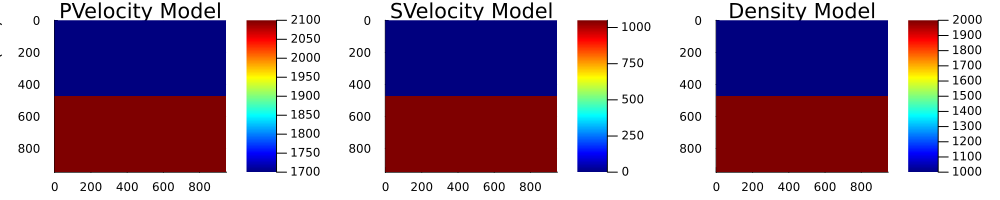

In [4]:
p1 = heatmap(range(x[1], stop=x[end], length=length(x)), range(z[1], stop=z[end], length=length(z)), cp_estendido,
    axis=:on, color=:auto,c=:jet, title="PVelocity Model", yflip=true, ylabel="Profundidade (Km)")

p2 = heatmap(range(x[1], stop=x[end], length=length(x)), range(z[1], stop=z[end], length=length(z)), cs_estendido,
    axis=:on, color=:auto,c=:jet, title="SVelocity Model", yflip=true,xlabel="Localização lateral (Km)")

p3 = heatmap(range(x[1], stop=x[end], length=length(x)), range(z[1], stop=z[end], length=length(z)), rho_estendido,
    axis=:on, color=:auto,c=:jet, title="Density Model", yflip=true, xlabel="Localização lateral (Km)")

plot(p1, p2, p3, layout=(1,3), size=(1000, 200))

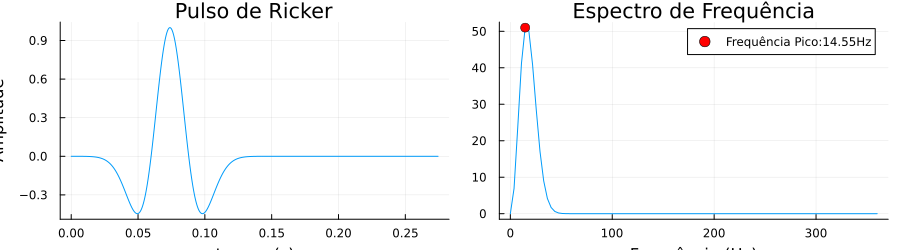

In [5]:
nt = 550
dt = 0.0005
f_corte = 48
t = 0:dt:(nt-1)*dt

source = wavelet(f_corte, t)
fftsource = abs.(fft(source))
freq = fftfreq(length(source), 1/(t[2]-t[1]))

p1 = plot(t, source, title="Pulso de Ricker", label=false, xlabel="tempo (s)", ylabel="Amplitude")
p2 = plot(freq[1:100], fftsource[1:100], label=false, title="Espectro de Frequência", xlabel="Frequência (Hz)")
scatter!([freq[argmax(fftsource)]], [maximum(fftsource)], color=:red, markersize=5, label=" Frequência Pico:$(round(freq[argmax(fftsource)],digits=2))Hz")

plot(p1,p2, layout=(1,2), size=(900, 250))

### Teste 1 - Receptor e fonte no meio acústico

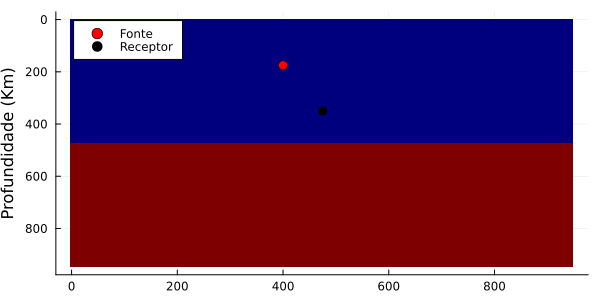

In [6]:
# Posições da fonte e do receptores para o teste 2
ixs = nx÷2 - 30
izs = borda + 30
ixr = nx÷2
izr = nz÷2 - 50

ixs_recp = ixr
izs_recp = izr
ixr_recp = ixs
izr_recp = izs

p1 = heatmap(range(x[1], stop=x[end], length=length(x)), range(z[1], stop=z[end], length=length(z)), cp_estendido,
    axis=:on, color=:auto,c=:jet, colorbar=false, yflip=true, ylabel="Profundidade (Km)")
    scatter!([ixs*dx], [izs*dz], color=:red, markersize=5, label="Fonte")
    scatter!([ixr*dx], [izr*dz], color=:black, markersize=5, label="Receptor ")

plot(p1, layout=(1,2), size=(600, 300), subtitle="Modelo de aquisição")

In [7]:
SismP_elastic, Vx_elastic, Vz_elastic = @time Prop2D_direct_elastico(nx,nz,nt,dx,dz,dt,source,rho_estendido,cp_estendido,cs_estendido,amortecedor,ixs,izs,ixr,izr)
SismP_acustic, Vx_acustic, Vz_acustic = @time Prop2D_direct_acustico(nx,nz,nt,dx,dz,dt,source,rho_estendido,cp_estendido,amortecedor,ixs,izs,ixr,izr)
println("finalizado")

Critério de estabilidade obedecido
 30.952274 seconds (3.30 M allocations: 15.006 GiB, 6.29% gc time, 16.49% compilation time)
Critério de estabilidade obedecido
  8.445249 seconds (1.08 M allocations: 7.023 GiB, 4.02% gc time, 21.88% compilation time)
finalizado


In [8]:
SismP_reci_elastic = @time reciprocalP_elastico(nx,nz,nt,dx,dz,dt,source,rho_estendido,cp_estendido,cs_estendido,amortecedor,ixs_recp,izs_recp,ixr_recp,izr_recp)
SismP_reci_acustic = @time reciprocalP_acustico(nx,nz,nt,dx,dz,dt,source,rho_estendido,cp_estendido,amortecedor,ixs_recp,izs_recp,ixr_recp,izr_recp)
println("finalizado")

Critério de estabilidade obedecido
 26.273927 seconds (1.46 M allocations: 14.888 GiB, 3.78% gc time, 15.56% compilation time)
Critério de estabilidade obedecido
  8.029452 seconds (691.95 k allocations: 6.998 GiB, 3.56% gc time, 20.05% compilation time)
finalizado


In [9]:
SismVx_reci_elastic = @time reciprocalVx_elastico(nx,nz,nt,dx,dz,dt,source,rho_estendido,cp_estendido,cs_estendido,amortecedor,ixs_recp,izs_recp,ixr_recp,izr_recp)
SismVx_reci_acustic = @time reciprocalVx_acustico(nx,nz,nt,dx,dz,dt,source,rho_estendido,cp_estendido,amortecedor,ixs_recp,izs_recp,ixr_recp,izr_recp)
println("finalizado")

Critério de estabilidade obedecido
 23.902715 seconds (1.45 M allocations: 14.888 GiB, 2.72% gc time, 16.93% compilation time)
Critério de estabilidade obedecido
  8.111286 seconds (689.69 k allocations: 6.998 GiB, 2.22% gc time, 25.50% compilation time)
finalizado


In [10]:
SismVz_reci_elastic = @time reciprocalVz_elastico(nx,nz,nt,dx,dz,dt,source,rho_estendido,cp_estendido,cs_estendido,amortecedor,ixs_recp,izs_recp,ixr_recp,izr_recp)
SismVz_reci_acustic = @time reciprocalVz_acustico(nx,nz,nt,dx,dz,dt,source,rho_estendido,cp_estendido,amortecedor,ixs_recp,izs_recp,ixr_recp,izr_recp)
println("finalizado")

Critério de estabilidade obedecido
 26.444802 seconds (1.45 M allocations: 14.888 GiB, 2.86% gc time, 19.10% compilation time)
Critério de estabilidade obedecido
  7.196080 seconds (689.68 k allocations: 6.998 GiB, 3.49% gc time, 20.56% compilation time)
finalizado


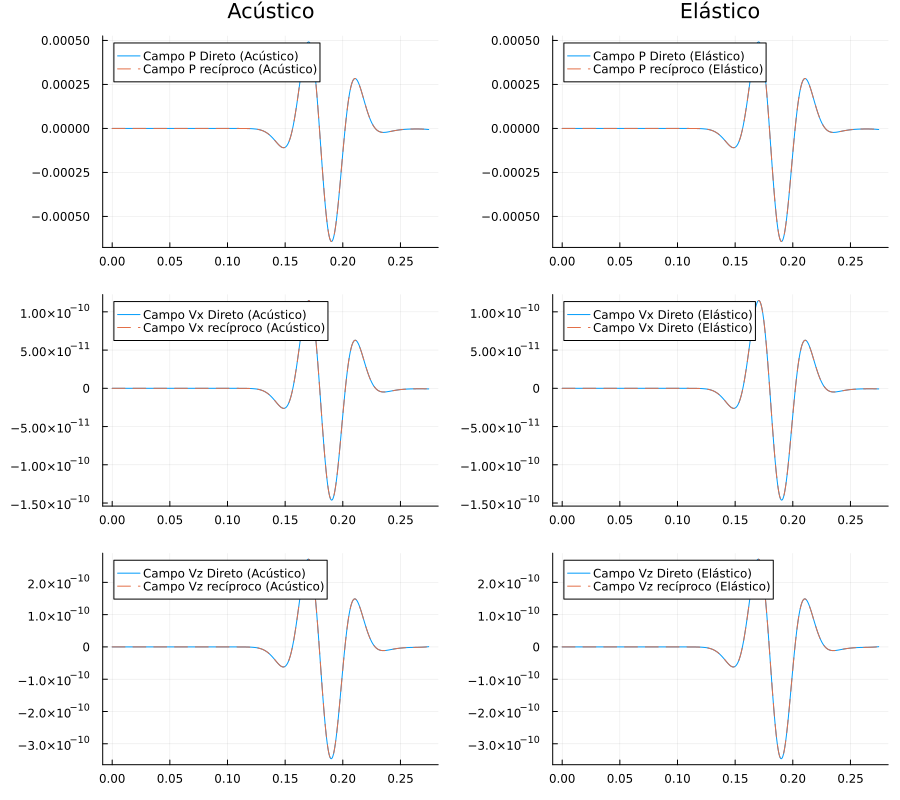

In [11]:
p1 = plot(t, SismP_acustic, title="Acústico", label="Campo P Direto (Acústico)")
plot!(t, SismP_reci_acustic,linestyle=:dash, label="Campo P recíproco (Acústico)")

p2 = plot(t, SismP_elastic, title="Elástico", label="Campo P Direto (Elástico)")
plot!(t, SismP_reci_elastic, linestyle=:dash, label="Campo P recíproco (Elástico)")

p3 = plot(t, Vx_acustic, label="Campo Vx Direto (Acústico)")
plot!(t, SismVx_reci_acustic, linestyle=:dash, label="Campo Vx recíproco (Acústico)")

p4 = plot(t, Vx_elastic, label="Campo Vx Direto (Elástico)")
plot!(t, SismVx_reci_elastic,linestyle=:dash, label="Campo Vx Direto (Elástico)")

p5 = plot(t, Vz_acustic, label="Campo Vz Direto (Acústico)")
plot!(t, SismVz_reci_acustic,linestyle=:dash, label="Campo Vz recíproco (Acústico)")

p6 = plot(t, Vz_elastic, label="Campo Vz Direto (Elástico)")
plot!(t, SismVz_reci_elastic, linestyle=:dash, label="Campo Vz recíproco (Elástico)")

plot(p1, p2, p3, p4, p5,p6, layout=(3,2), size=(900, 800))

### Teste 2 - Receptor e fonte no leito marinho

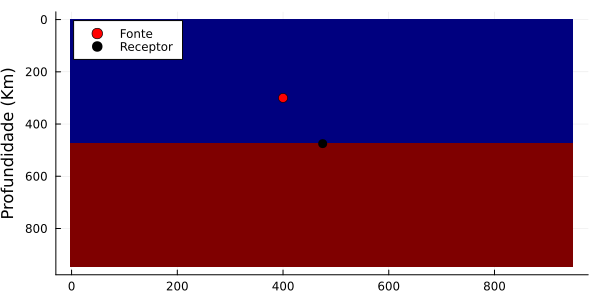

In [12]:
# Posições da fonte e do receptores para o teste 2
ixs = nx÷2 - 30
izs = borda + 80
ixr = nx÷2
izr = nz÷2

ixs_recp = ixr
izs_recp = izr
ixr_recp = ixs
izr_recp = izs

p1 = heatmap(range(x[1], stop=x[end], length=length(x)), range(z[1], stop=z[end], length=length(z)), cp_estendido,
    axis=:on, color=:auto,c=:jet, colorbar=false, yflip=true, ylabel="Profundidade (Km)")
    scatter!([ixs*dx], [izs*dz], color=:red, markersize=5, label="Fonte")
    scatter!([ixr*dx], [izr*dz], color=:black, markersize=5, label="Receptor ")

plot(p1, layout=(1,2), size=(600, 300), subtitle="Modelo de aquisição")

In [13]:
SismP_elastic, Vx_elastic, Vz_elastic = @time Prop2D_direct_elastico(nx,nz,nt,dx,dz,dt,source,rho_estendido,cp_estendido,cs_estendido,amortecedor,ixs,izs,ixr,izr)
SismP_acustic, Vx_acustic, Vz_acustic = @time Prop2D_direct_acustico(nx,nz,nt,dx,dz,dt,source,rho_estendido,cp_estendido,amortecedor,ixs,izs,ixr,izr)
println("finalizado")

Critério de estabilidade obedecido
 14.480631 seconds (56.16 k allocations: 14.803 GiB, 2.71% gc time)
Critério de estabilidade obedecido
  4.880472 seconds (26.43 k allocations: 6.957 GiB, 1.84% gc time)
finalizado


In [14]:
SismP_reci_elastic = @time reciprocalP_elastico(nx,nz,nt,dx,dz,dt,source,rho_estendido,cp_estendido,cs_estendido,amortecedor,ixs_recp,izs_recp,ixr_recp,izr_recp)
SismP_reci_acustic = @time reciprocalP_acustico(nx,nz,nt,dx,dz,dt,source,rho_estendido,cp_estendido,amortecedor,ixs_recp,izs_recp,ixr_recp,izr_recp)
println("finalizado")

Critério de estabilidade obedecido
 17.949669 seconds (56.16 k allocations: 14.803 GiB, 2.46% gc time)
Critério de estabilidade obedecido
  6.876756 seconds (26.55 k allocations: 6.957 GiB, 3.67% gc time)
finalizado


In [15]:
SismVx_reci_elastic = @time reciprocalVx_elastico(nx,nz,nt,dx,dz,dt,source,rho_estendido,cp_estendido,cs_estendido,amortecedor,ixs_recp,izs_recp,ixr_recp,izr_recp)
SismVx_reci_acustic = @time reciprocalVx_acustico(nx,nz,nt,dx,dz,dt,source,rho_estendido,cp_estendido,amortecedor,ixs_recp,izs_recp,ixr_recp,izr_recp)
println("finalizado")

Critério de estabilidade obedecido
 16.886960 seconds (56.16 k allocations: 14.803 GiB, 2.91% gc time)
Critério de estabilidade obedecido
  5.209597 seconds (26.43 k allocations: 6.957 GiB, 1.94% gc time)
finalizado


In [16]:
SismVz_reci_elastic = @time reciprocalVz_elastico(nx,nz,nt,dx,dz,dt,source,rho_estendido,cp_estendido,cs_estendido,amortecedor,ixs_recp,izs_recp,ixr_recp,izr_recp)
SismVz_reci_acustic = @time reciprocalVz_acustico(nx,nz,nt,dx,dz,dt,source,rho_estendido,cp_estendido,amortecedor,ixs_recp,izs_recp,ixr_recp,izr_recp)
println("finalizado")

Critério de estabilidade obedecido
 22.495254 seconds (56.16 k allocations: 14.803 GiB, 2.17% gc time)
Critério de estabilidade obedecido
  7.441205 seconds (26.43 k allocations: 6.957 GiB, 3.48% gc time)
finalizado


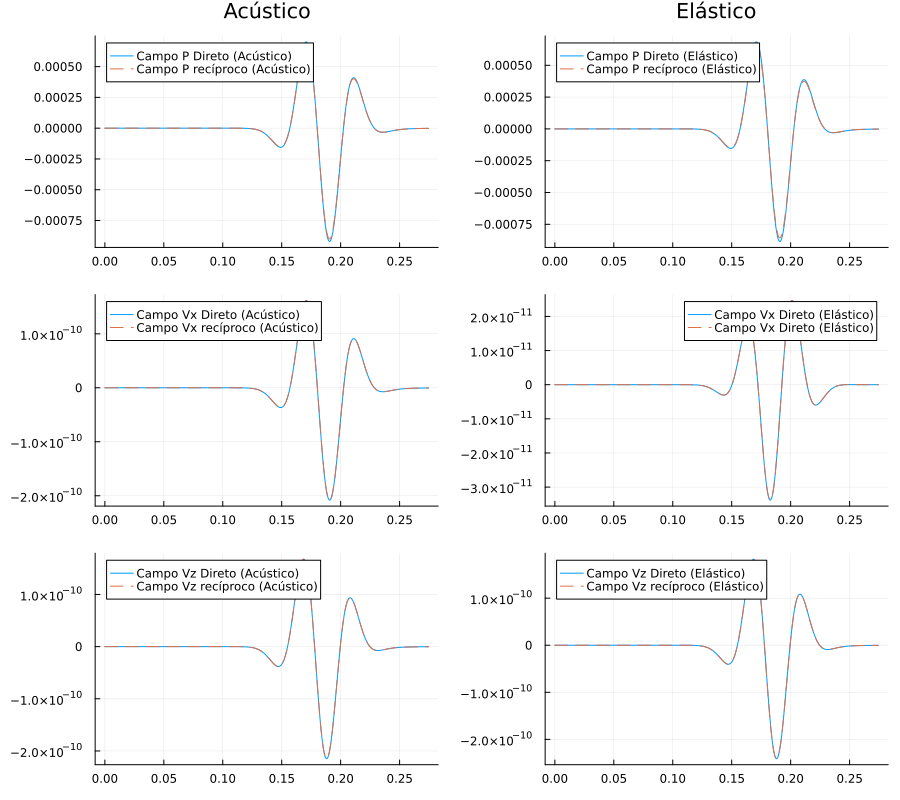

In [17]:
p1 = plot(t, SismP_acustic, title="Acústico", label="Campo P Direto (Acústico)")
plot!(t, SismP_reci_acustic,linestyle=:dash, label="Campo P recíproco (Acústico)")

p2 = plot(t, SismP_elastic, title="Elástico", label="Campo P Direto (Elástico)")
plot!(t, SismP_reci_elastic, linestyle=:dash, label="Campo P recíproco (Elástico)")

p3 = plot(t, Vx_acustic, label="Campo Vx Direto (Acústico)")
plot!(t, SismVx_reci_acustic, linestyle=:dash, label="Campo Vx recíproco (Acústico)")

p4 = plot(t, Vx_elastic, label="Campo Vx Direto (Elástico)")
plot!(t, SismVx_reci_elastic,linestyle=:dash, label="Campo Vx Direto (Elástico)")

p5 = plot(t, Vz_acustic, label="Campo Vz Direto (Acústico)")
plot!(t, SismVz_reci_acustic,linestyle=:dash, label="Campo Vz recíproco (Acústico)")

p6 = plot(t, Vz_elastic, label="Campo Vz Direto (Elástico)")
plot!(t, SismVz_reci_elastic, linestyle=:dash, label="Campo Vz recíproco (Elástico)")

plot(p1, p2, p3, p4, p5,p6, layout=(3,2), size=(900, 800))

### Teste 3 - Receptor e fonte em meios diferentes

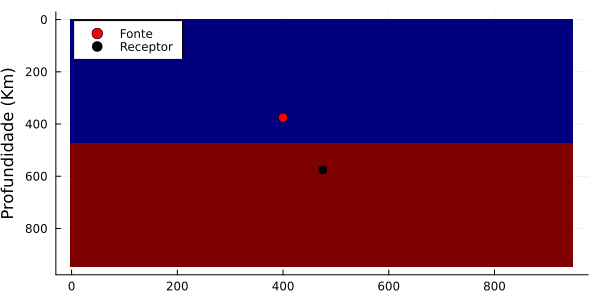

In [18]:
# Posições da fonte e do receptores para o teste 2
ixs = nx÷2 - 30
izs = nz÷2 - 40
ixr = nx÷2
izr = nz÷2 + 40

ixs_recp = ixr
izs_recp = izr
ixr_recp = ixs
izr_recp = izs

p1 = heatmap(range(x[1], stop=x[end], length=length(x)), range(z[1], stop=z[end], length=length(z)), cp_estendido,
    axis=:on, color=:auto,c=:jet, colorbar=false, yflip=true, ylabel="Profundidade (Km)")
    scatter!([ixs*dx], [izs*dz], color=:red, markersize=5, label="Fonte")
    scatter!([ixr*dx], [izr*dz], color=:black, markersize=5, label="Receptor ")

plot(p1, layout=(1,2), size=(600, 300), subtitle="Modelo de aquisição")

In [19]:
SismP_elastic, Vx_elastic, Vz_elastic = @time Prop2D_direct_elastico(nx,nz,nt,dx,dz,dt,source,rho_estendido,cp_estendido,cs_estendido,amortecedor,ixs,izs,ixr,izr)
SismP_acustic, Vx_acustic, Vz_acustic = @time Prop2D_direct_acustico(nx,nz,nt,dx,dz,dt,source,rho_estendido,cp_estendido,amortecedor,ixs,izs,ixr,izr)
println("finalizado")

Critério de estabilidade obedecido
 20.781789 seconds (56.16 k allocations: 14.803 GiB, 2.34% gc time)
Critério de estabilidade obedecido
  5.762662 seconds (26.43 k allocations: 6.957 GiB, 1.89% gc time)
finalizado


In [20]:
SismP_reci_elastic = @time reciprocalP_elastico(nx,nz,nt,dx,dz,dt,source,rho_estendido,cp_estendido,cs_estendido,amortecedor,ixs_recp,izs_recp,ixr_recp,izr_recp)
SismP_reci_acustic = @time reciprocalP_acustico(nx,nz,nt,dx,dz,dt,source,rho_estendido,cp_estendido,amortecedor,ixs_recp,izs_recp,ixr_recp,izr_recp)
println("finalizado")

Critério de estabilidade obedecido
 16.492983 seconds (56.16 k allocations: 14.803 GiB, 2.38% gc time)
Critério de estabilidade obedecido
  5.109877 seconds (26.43 k allocations: 6.957 GiB, 3.63% gc time)
finalizado


In [21]:
SismVx_reci_elastic = @time reciprocalVx_elastico(nx,nz,nt,dx,dz,dt,source,rho_estendido,cp_estendido,cs_estendido,amortecedor,ixs_recp,izs_recp,ixr_recp,izr_recp)
SismVx_reci_acustic = @time reciprocalVx_acustico(nx,nz,nt,dx,dz,dt,source,rho_estendido,cp_estendido,amortecedor,ixs_recp,izs_recp,ixr_recp,izr_recp)
println("finalizado")

Critério de estabilidade obedecido
 14.104164 seconds (56.15 k allocations: 14.803 GiB, 2.79% gc time)
Critério de estabilidade obedecido
  4.316565 seconds (26.43 k allocations: 6.957 GiB, 2.28% gc time)
finalizado


In [22]:
SismVz_reci_elastic = @time reciprocalVz_elastico(nx,nz,nt,dx,dz,dt,source,rho_estendido,cp_estendido,cs_estendido,amortecedor,ixs_recp,izs_recp,ixr_recp,izr_recp)
SismVz_reci_acustic = @time reciprocalVz_acustico(nx,nz,nt,dx,dz,dt,source,rho_estendido,cp_estendido,amortecedor,ixs_recp,izs_recp,ixr_recp,izr_recp)
println("finalizado")

Critério de estabilidade obedecido
 14.497390 seconds (56.16 k allocations: 14.803 GiB, 2.13% gc time)
Critério de estabilidade obedecido
  6.484010 seconds (26.43 k allocations: 6.957 GiB, 3.29% gc time)
finalizado


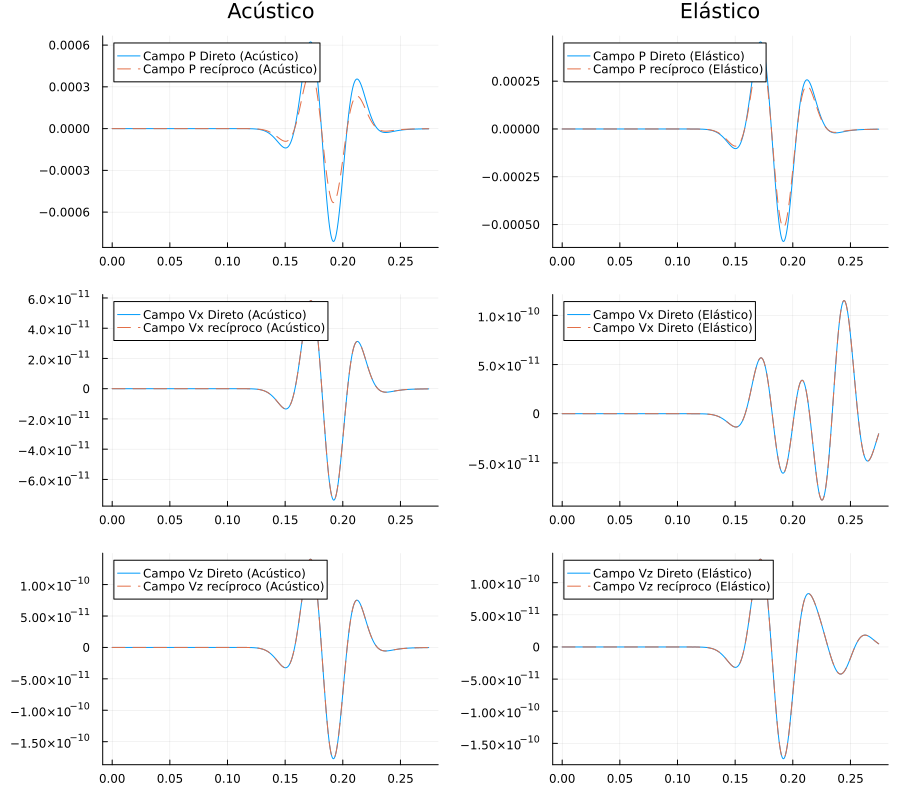

In [23]:
p1 = plot(t, SismP_acustic, title="Acústico", label="Campo P Direto (Acústico)")
plot!(t, SismP_reci_acustic*2,linestyle=:dash, label="Campo P recíproco (Acústico)")

p2 = plot(t, SismP_elastic, title="Elástico", label="Campo P Direto (Elástico)")
plot!(t, SismP_reci_elastic*2, linestyle=:dash, label="Campo P recíproco (Elástico)")

p3 = plot(t, Vx_acustic, label="Campo Vx Direto (Acústico)")
plot!(t, SismVx_reci_acustic, linestyle=:dash, label="Campo Vx recíproco (Acústico)")

p4 = plot(t, Vx_elastic, label="Campo Vx Direto (Elástico)")
plot!(t, SismVx_reci_elastic,linestyle=:dash, label="Campo Vx Direto (Elástico)")

p5 = plot(t, Vz_acustic, label="Campo Vz Direto (Acústico)")
plot!(t, SismVz_reci_acustic,linestyle=:dash, label="Campo Vz recíproco (Acústico)")

p6 = plot(t, Vz_elastic, label="Campo Vz Direto (Elástico)")
plot!(t, SismVz_reci_elastic, linestyle=:dash, label="Campo Vz recíproco (Elástico)")

plot(p1, p2, p3, p4, p5,p6, layout=(3,2), size=(900, 800))